In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
from scipy.stats import skew,boxcox
from scipy.special import boxcox1p

warnings.filterwarnings("ignore")

data = pd.read_csv("./encodeData.csv",index_col=0)

1.对于 Value，Wage为0的，不具备参考价值
=

In [2]:
mask = (data['Value'] == 0) | (data['Wage'] == 0)
data.drop(data[mask].index, inplace=True)
data.shape

(17907, 747)

2.去除共线特征
=

In [3]:
PART1 = ['LS','ST','RS','LW','LF','CF','RF','RW',
         'LAM','CAM','RAM','LM','LCM','CM','RCM','RM']
PART2 = ['LWB','LDM','CDM','RDM','RWB','LB','LCB',
         'CB','RCB','RB']

data['Behavior1'] = data[PART1].sum(axis=1)/len(PART1)
data['Behavior2'] = data[PART2].sum(axis=1)/len(PART2)

data.drop(PART1,axis=1,inplace=True)
data.drop(PART2,axis=1,inplace=True)
data.shape

(17907, 723)

In [4]:
GK = ['GKDiving','GKHandling','GKKicking','GKPositioning','GKReflexes']
data['GKBehavior'] = data[GK].sum(axis=1)/len(GK)
data.drop(GK,axis=1,inplace=True)
data.shape

(17907, 719)

3.离群点
=

<AxesSubplot:xlabel='Overall'>

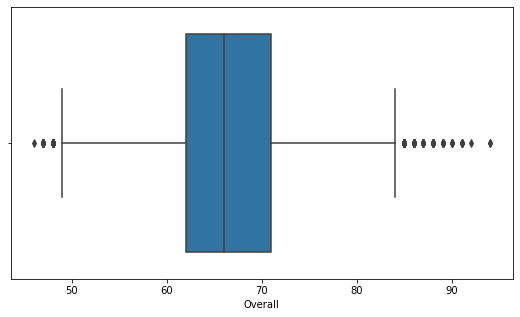

In [5]:
plt.figure(figsize=(9,5))
sns.boxplot(data['Overall'])

<AxesSubplot:xlabel='Wage'>

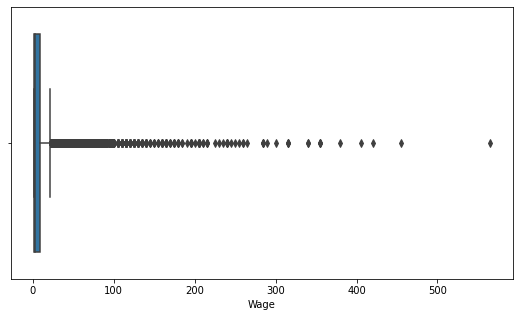

In [6]:
plt.figure(figsize=(9,5))
sns.boxplot(data['Wage'])

<AxesSubplot:xlabel='Wage'>

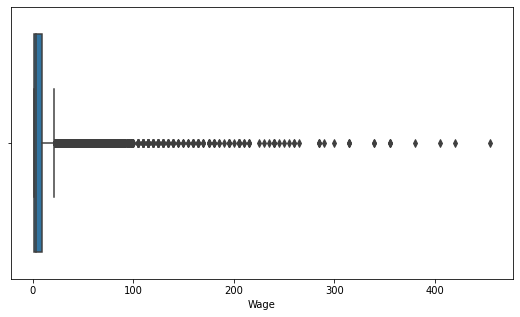

In [7]:
mask = data['Wage'] > 500
data.drop(data[mask].index,inplace=True)

plt.figure(figsize=(9,5))
sns.boxplot(data['Wage'])

<AxesSubplot:xlabel='Value'>

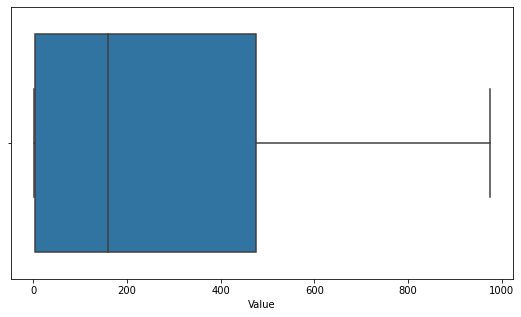

In [8]:
plt.figure(figsize=(9,5))
sns.boxplot(data['Value'])

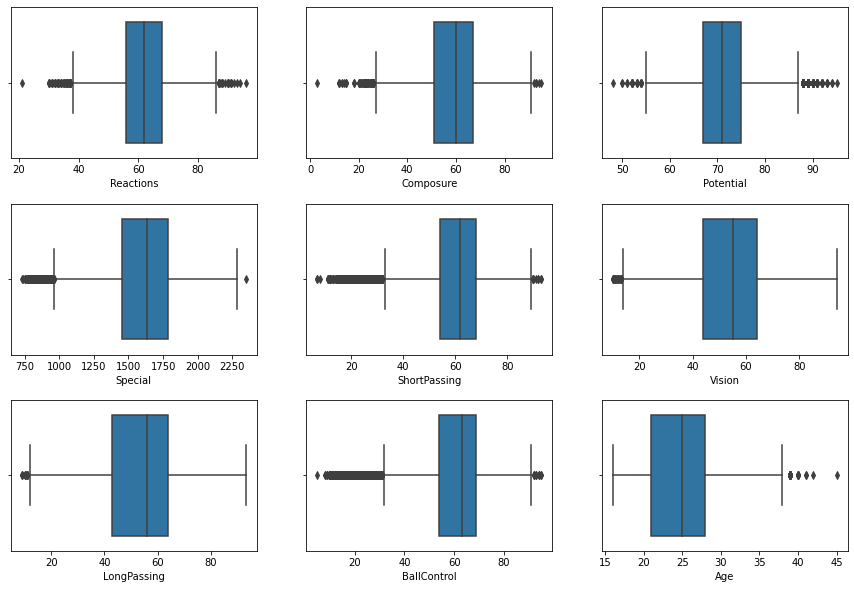

In [9]:
'''对EDA中找出的与 OVERALL相关性最强的几个特征查看离群点'''
'''与Wage相关性最强的特征与Overall几乎相同'''

overallFeatures = ['Reactions','Composure','Potential','Special',
                   'ShortPassing','Vision','LongPassing','BallControl','Age']


fig, ax = plt.subplots(3,3,figsize=(15,10))
plt.subplots_adjust(hspace=0.3)
r,c = 0,0
for col in overallFeatures:
    sns.boxplot(data[col],ax=ax[r,c])
    if c == 2:
        c = 0
        r += 1
    else: c += 1
plt.show()

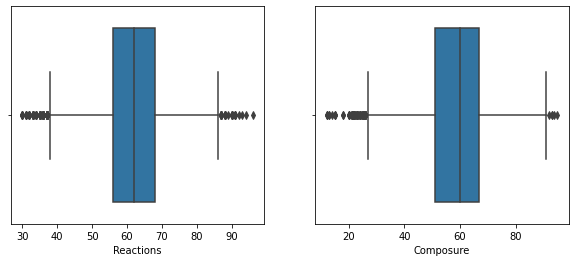

In [10]:
mask = (data['Reactions'] < 25) | (data['Composure'] < 5)
data.drop(data[mask].index,inplace=True)

fig, ax = plt.subplots(1,2,figsize=(10,4))
sns.boxplot(data['Reactions'],ax=ax[0])
sns.boxplot(data['Composure'],ax=ax[1])
plt.show()

4.构建新特征
=

In [11]:
# BMI
data['BMI'] = data['Weight']/(data['Height']*data['Height'])
# 在该球队出站多少年
data['Loyal'] = data['Contract Valid Until'] - data['Joined']
# 步法能力
data['Pace'] = (data['Acceleration'] + data['SprintSpeed'])/2
# 射门能力
data['Shooting'] = (data['Finishing'] + data['ShotPower'] + data['LongShots'] + data['Positioning'] + data['Volleys'] + data['HeadingAccuracy'])/6
# 过人能力
data['Passing'] = (data['ShortPassing'] + data['LongPassing'] + data['Crossing'] + data['Curve'] + data['Vision'])/5
# 带球能力
data['Dribble'] = (data['Agility'] + data['Balance'] + data['BallControl'] + data['Composure'] + data['Dribbling'] + data['Reactions'])/6
# 防守能力
data['Defending'] = (data['Interceptions'] + data['Marking'] + data['StandingTackle'] + data['SlidingTackle'])/4
# 身体素质
data['Physical'] = (data['Aggression'] + data['Jumping'] + data['Stamina'] + data['Strength'])/4

In [12]:
'''位置特征：利用basic1.ipynb中，分析的ATK,GK,MID,DF四个位置最重要的能力'''
'''与上面建立特征重合的部分就不加了'''

data['PositionBehave'] = None
mask = (data['ATK'] == 1) | (data['Forward'] == 1)
data.loc[mask, 'PositionBehave'] = (data.loc[mask, 'Acceleration'] + data.loc[mask, 'Agility'] + data.loc[mask,
                                    'Shooting'] + data.loc[mask, 'Passing'] + data.loc[mask, 'BallControl'] + data.loc[mask, 'Jumping'])/6

mask = (data['Mid'] == 1)
data.loc[mask, 'PositionBehave'] = (
    data.loc[mask, 'Acceleration'] + data.loc[mask, 'Dribble'] + data.loc[mask, 'Jumping'])/3

mask = (data['Guard'] == 1)
data.loc[mask, 'PositionBehave'] = (data.loc[mask, 'Defending'] + data.loc[mask, 'Aggression'] +
                                    data.loc[mask, 'Jumping'] + data.loc[mask, 'Acceleration'] + data.loc[mask, 'Balance'])/5

mask = (data['GK'] == 1)
data.loc[mask, 'PositionBehave'] = (
    data.loc[mask, 'GKBehavior'] + data.loc[mask, 'Jumping'])/2

data['PositionBehave'].isnull().sum()

0

In [13]:
data.shape

(17904, 728)

5.数据变换
=

In [14]:
data.columns[range(50)].values

array(['Age', 'Overall', 'Potential', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Real Face', 'Joined', 'Contract Valid Until',
       'Height', 'Weight', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed',
       'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping',
       'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions',
       'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking',
       'StandingTackle', 'SlidingTackle', 'Release Clause', 'ATK',
       'Forward', 'GK', 'Guard', 'Mid'], dtype=object)

In [15]:
data.columns[range(716,728)].values

array(['Behavior1', 'Behavior2', 'GKBehavior', 'BMI', 'Loyal', 'Pace',
       'Shooting', 'Passing', 'Dribble', 'Defending', 'Physical',
       'PositionBehave'], dtype=object)

In [16]:
useCols = list(data.columns[range(50)].values)
useCols.extend(list(data.columns[range(716,728)].values))
len(useCols)

62

In [17]:
skewed_feats = data[useCols].apply(lambda x:skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew':skewed_feats})
skewness[skewness["Skew"].abs()>1]

,Skew
Wage,7.364792
Forward,4.279370
International Reputation,4.036265
Real Face,2.817698
GKBehavior,2.535720
GK,2.476074
ATK,2.054811
Loyal,1.746326
Release Clause,1.175919
Dribbling,-1.089973


In [18]:
skewCols = ['GKBehavior','Release Clause','Dribbling','ShortPassing','BallControl']

for col in skewCols:
    data[col], lam = boxcox(data[col]) 

skewed_feats = data[skewCols].apply(lambda x:skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew':skewed_feats})
skewness

,Skew
Release Clause,0.074521
ShortPassing,-0.222942
BallControl,-0.332977
Dribbling,-0.434321
GKBehavior,-1.104663


In [19]:
data.to_csv("./train.csv")